# Project: Investigating the Relationship Between News Sentiment and Market Movements
**Author:** Sebastian Bizzi

**Date:** October 23, 2025

---
## 1. Project Goal & Context

Financial markets are influenced by countless factors, including the constant stream of news. This project aims to rigorously investigate the potential relationship between the sentiment expressed in daily financial news headlines and the short-term movements of a major stock market index (S&P 500).

The core objective is not necessarily to build a perfect predictive model, but to conduct a **proof-of-concept analysis** using historical data to determine if a discernible, quantifiable link exists using common NLP and data analysis techniques. This simulates the initial research phase a FinTech or Media Intelligence company might undertake before investing in a complex predictive product.

---
## 2. Methodology & Tools

This analysis utilizes a multi-step approach, leveraging Python within Google Colab and several key libraries:

* **Data Collection:**
    * Historical financial news headlines (5 years) were sourced programmatically from **The Guardian API**. A Python script using the `requests` library was implemented to query the API's 'business' section for the specified date range, handling pagination to retrieve all available headlines.
    * Corresponding daily S&P 500 (`^GSPC`) data was obtained using the **`yfinance`** library for the same 5-year period.
* **Data Processing & Feature Engineering:**
    * **Pandas** was used for data cleaning (dates, text), merging the news and market datasets by date, and creating features like daily aggregated headlines and market direction (up/down).
    * Text cleaning involved standard techniques (lowercase, removing non-alphabetic characters).
* **Sentiment Analysis:**
    * The **NLTK VADER** library was applied to quantify the sentiment of daily aggregated headlines.
* **Topic Modeling:**
    * **Scikit-learn (TF-IDF & NMF)** was used to identify latent topics within the news headlines to explore thematic influences.
* **Correlation & Predictive Analysis:**
    * Statistical comparisons (average sentiment/topics on up vs. down days) were performed.
    * A basic **Scikit-learn Logistic Regression** model was trained to test the predictive power of sentiment and topics for the *next day's* market direction.
* **Visualization:** **Matplotlib** and **Seaborn** were used to illustrate findings.

---
## 3. Notebook Structure

This notebook follows the logical steps of the analysis:
1.  Data Collection (Guardian API & yfinance)
2.  Data Processing and Merging
3.  Sentiment Analysis (VADER)
4.  Initial Correlation (Sentiment vs. Market Direction)
5.  Feature Engineering (Volume Analysis & Topic Modeling)
6.  Advanced Correlation (Topics vs. Market Direction, Sentiment within Topics)
7.  Basic Predictive Modeling (Logistic Regression)
8.  Final Conclusion & Strategic Recommendations

### Stage 1: Proof of Concept (Historical Analysis)

####Objective:
Validate the core analysis logic using a robust historical dataset.
#### Tools:
Google Colab (Python), Pandas, NLTK/Vader (Sentiment Analysis), Matplotlib/Seaborn, The Guardian API, yfinance.
#### Process:
Build Historical Dataset: Use The Guardian API to download several years of historical headlines from relevant financial sections. Use yfinance to download corresponding S&P 500 data. Clean, process, and merge these into a single CSV.
Sentiment Analysis: Apply sentiment analysis (VADER) to the cleaned daily headlines to create a time series of market sentiment.
Correlation Analysis: Compare the sentiment time series with the market direction (up/down) to identify potential relationships.
(Optional) Basic ML Model: Train a simple machine learning model (e.g., Logistic Regression) using historical sentiment to predict the next day's market direction and evaluate its accuracy.
Outcome: A validated analysis methodology and a well-documented case study demonstrating the feasibility (or limitations) of using news sentiment as a market indicator.

#### Step 1: Download Historical News Data (The Guardian)

We begin Stage 1 by building our historical dataset. The first step is to collect relevant news headlines from The Guardian's Open Platform API over a significant period (e.g., the last 5 years).

The following script will:
1.  Securely access our Guardian API key stored in Colab Secrets.
2.  Install the necessary `requests` library.
3.  Define the parameters for the API call (date range, section, page size).
4.  Implement a loop to handle pagination and download all relevant headlines.
5.  Store the results in a Pandas DataFrame.



### Stage 1: Proof of Concept (Historical Analysis)
#### Step 1: Download Historical News Data (The Guardian)

We begin Stage 1 by building our historical dataset. The first step is to collect relevant news headlines from The Guardian's Open Platform API over a significant period (e.g., the last 5 years).

The following script will:
1.  Securely access our Guardian API key stored in Colab Secrets.
2.  Install the necessary `requests` library (though it's usually pre-installed in Colab).
3.  Define the parameters for the API call (date range, section, page size).
4.  Implement a loop to handle pagination and download all relevant headlines.
5.  Store the results in a Pandas DataFrame.

In [ ]:
# --- Step 1: Download Historical News Data (The Guardian) ---

import requests
import pandas as pd
from google.colab import userdata
from datetime import datetime, timedelta
import time # Import time for adding delays

# 1. Access the API Key securely
try:
    api_key = userdata.get('GUARDIAN_API_KEY')
except Exception as e:
    print("Error: Could not find the secret 'GUARDIAN_API_KEY'.")
    print("Please ensure you've saved it correctly in the Secrets panel (🔑).")
    raise e

# 2. Define search parameters
# Adjust dates for a different period if needed
start_date = (datetime.now() - timedelta(days=5*365)).strftime('%Y-%m-%d') # Last 5 years
end_date = datetime.now().strftime('%Y-%m-%d')
section = 'business' # Focus on the business/finance section
page_size = 50       # Max allowed per page by the API
api_url = 'https://content.guardianapis.com/search'

all_headlines = []
current_page = 1
total_pages = 1 # Initialize to 1; the API will tell us the actual total

print(f"Starting download of headlines from {start_date} to {end_date}...")

# 3. Loop to handle pagination
while current_page <= total_pages:
    params = {
        'api-key': api_key,
        'section': section,
        'from-date': start_date,
        'to-date': end_date,
        'page-size': page_size,
        'page': current_page,
        'show-fields': 'headline', # We only need the headline
        'order-by': 'oldest'       # Process from oldest to newest
    }

    try:
        response = requests.get(api_url, params=params)
        response.raise_for_status() # Raise an error for bad status codes (4xx or 5xx)
        data = response.json()['response']

        # Update total_pages on the first iteration
        if current_page == 1:
            total_pages = data.get('pages', 1)
            print(f"Total pages to download: {total_pages}")

        # Extract headlines and dates from the current page
        results = data.get('results', [])
        if not results:
             print(f"No results found on page {current_page}. Stopping.")
             break

        for item in results:
            # Ensure headline field exists before accessing it
            headline_text = item.get('fields', {}).get('headline', None)
            if headline_text: # Only append if headline exists
                 all_headlines.append({
                      # Convert publication date string to just the date part
                      'Date': pd.to_datetime(item['webPublicationDate']).date(),
                      'Headline': headline_text
                 })

        print(f"Downloaded page {current_page}/{total_pages}...")

        # Be polite to the API: add a small delay between requests
        time.sleep(0.5) # Wait half a second

        current_page += 1

    except requests.exceptions.RequestException as e:
        print(f"Error during API request on page {current_page}: {e}")
        break
    except KeyError as e:
         print(f"Error processing API response on page {current_page}: Missing key {e}")
         print("Response data sample:", str(data)[:200]) # Print first 200 chars of response
         break
    except Exception as e:
         print(f"An unexpected error occurred on page {current_page}: {e}")
         break

# 4. Create the DataFrame
news_df = pd.DataFrame(all_headlines)

# Convert 'Date' column to datetime objects *after* creating the DataFrame
if 'Date' in news_df.columns:
    news_df['Date'] = pd.to_datetime(news_df['Date'])

print("\n" + "="*50)
print(f"News download complete. Total headlines collected: {len(news_df)}")
if not news_df.empty:
    print("`news_df` DataFrame created successfully.")
    news_df.info() # Check info
else:
    print("No headlines were collected.")

Starting download of headlines from 2020-10-22 to 2025-10-21...
Total pages to download: 369
Downloaded page 1/369...
Downloaded page 2/369...
Downloaded page 3/369...
Downloaded page 4/369...
Downloaded page 5/369...
Downloaded page 6/369...
Downloaded page 7/369...
Downloaded page 8/369...
Downloaded page 9/369...
Downloaded page 10/369...
Downloaded page 11/369...
Downloaded page 12/369...
Downloaded page 13/369...
Downloaded page 14/369...
Downloaded page 15/369...
Downloaded page 16/369...
Downloaded page 17/369...
Downloaded page 18/369...
Downloaded page 19/369...
Downloaded page 20/369...
Downloaded page 21/369...
Downloaded page 22/369...
Downloaded page 23/369...
Downloaded page 24/369...
Downloaded page 25/369...
Downloaded page 26/369...
Downloaded page 27/369...
Downloaded page 28/369...
Downloaded page 29/369...
Downloaded page 30/369...
Downloaded page 31/369...
Downloaded page 32/369...
Downloaded page 33/369...
Downloaded page 34/369...
Downloaded page 35/369...
Downlo

### Step 2: Collect Market Data (S&P 500)

Now that we have the news headlines, we need the corresponding market data to perform our correlation analysis. We will use the `yfinance` library to download the historical price data for the S&P 500 index (ticker symbol: `^GSPC`).

The goal is to have a DataFrame containing the daily closing prices, which we can then process to determine the market's direction (up or down) each day.

In [ ]:
# --- Step 2: Collect Market Data (Corrected) ---

# Install yfinance if needed
# !pip install yfinance

import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta # Make sure datetime is imported

# 1. Define the ticker
ticker = "^GSPC"

# *** FIX: Define the date range AGAIN in this cell ***
# Use the same 5-year period as the news download
start_date = (datetime.now() - timedelta(days=5*365)).strftime('%Y-%m-%d')
end_date = datetime.now().strftime('%Y-%m-%d')

# 3. Download historical data for the defined period
# Use start= and end= parameters
sp500_data = yf.download(ticker, start=start_date, end=end_date)

# 4. Verify results
print(f"Historical data for {ticker} downloaded successfully.")
if not sp500_data.empty:
    print(f"Date range is from {sp500_data.index.min().date()} to {sp500_data.index.max().date()}.")
    print("\n--- Last 5 days of S&P 500 data ---")
    print(sp500_data.tail())
else:
    print("Could not download market data.")

/tmp/ipython-input-24413403.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500_data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Historical data for ^GSPC downloaded successfully.
Date range is from 2020-10-22 to 2025-10-20.

--- Last 5 days of S&P 500 data ---
Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2025-10-14  6644.310059  6680.700195  6555.069824  6602.490234  5666920000
2025-10-15  6671.060059  6724.120117  6612.109863  6688.270020  5633060000
2025-10-16  6629.069824  6709.339844  6593.990234  6689.020020  6048180000
2025-10-17  6664.009766  6678.879883  6603.759766  6613.270020  5358120000
2025-10-20  6735.129883  6744.350098  6690.049805  6690.049805  4672170000


### Step 3: Process and Merge News and Market Data

Having successfully downloaded the historical news headlines (`news_df`) and the S&P 500 market data (`sp500_data`) for the same 5-year period, we now need to prepare and combine them into a single, unified DataFrame for analysis.

This involves:
1.  **Processing News Data:** Grouping all headlines from the same day into a single text entry and ensuring the date format is consistent.
2.  **Processing Market Data:** Calculating the daily market direction (1 for up, 0 for down/flat) based on the closing price.
3.  **Merging DataFrames:** Joining the processed news and market data tables using the 'Date' as the key, ensuring we only keep days present in both datasets.

In [ ]:
# --- Step 3: Process and Merge News and Market Data ---

# 1. Process News Data
# Group all headlines for the same date into a single string
daily_news = news_df.groupby('Date')['Headline'].apply(' '.join).reset_index()
daily_news.rename(columns={'Headline': 'Headlines'}, inplace=True)

print("--- Processed News DataFrame (daily_news) ---")
print(f"Number of days with headlines: {len(daily_news)}")
print(daily_news.head())

# 2. Process Market Data
# Ensure the index (Date) is datetime type
sp500_data.index = pd.to_datetime(sp500_data.index)

# Create a simplified DataFrame for market direction
market_df = pd.DataFrame()
market_df['Date'] = sp500_data.index
# Access the 'Close' column correctly
try:
    market_df['Close'] = sp500_data['Close'].values
except KeyError:
    sp500_data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in sp500_data.columns.values]
    market_df['Close'] = sp500_data['Close'].values

# Calculate price change and market direction
market_df['Price_Change'] = market_df['Close'].diff()
market_df['Market_Direction'] = (market_df['Price_Change'] > 0).astype(int)
market_df = market_df.dropna(subset=['Price_Change'])

print("\n--- Simplified S&P 500 DataFrame (market_df) ---")
print(f"Number of market days: {len(market_df)}")
print(market_df.tail())

# 3. Merge DataFrames
# Make sure both 'Date' columns are datetime objects before merging
daily_news['Date'] = pd.to_datetime(daily_news['Date'])
market_df['Date'] = pd.to_datetime(market_df['Date'])

analysis_df = pd.merge(daily_news, market_df, on='Date', how='inner')

print("\n" + "="*50)
print("--- Final DataFrame for Analysis (analysis_df) ---")
if not analysis_df.empty:
    print(f"Merge successful! Found {len(analysis_df)} matching trading days with news.")
    print(analysis_df[['Date', 'Headlines', 'Market_Direction']].head())
    print("\n--- Info ---")
    analysis_df.info()
else:
    print("Merge failed: No matching dates found between news and market data.")

--- Processed News DataFrame (daily_news) ---
Number of days with headlines: 1821
        Date                                          Headlines
0 2020-10-22  British Airways owner IAG slashes flights afte...
1 2020-10-23  Barclays warns of cuts as Covid pushes bad deb...
2 2020-10-24  Cold comfort: UK outdoor swimming venues stay ...
3 2020-10-25  Why China's dramatic economic recovery might n...
4 2020-10-26  Big tech accused of avoiding $2.8bn in tax to ...

--- Simplified S&P 500 DataFrame (market_df) ---
Number of market days: 1253
           Date        Close  Price_Change  Market_Direction
1249 2025-10-14  6644.310059    -10.410156                 0
1250 2025-10-15  6671.060059     26.750000                 1
1251 2025-10-16  6629.069824    -41.990234                 0
1252 2025-10-17  6664.009766     34.939941                 1
1253 2025-10-20  6735.129883     71.120117                 1

--- Final DataFrame for Analysis (analysis_df) ---
Merge successful! Found 1253 matching 

### Step 4: Sentiment Analysis

With our unified DataFrame (`analysis_df`) containing daily headlines and market direction, the next step is to quantify the sentiment of the news text for each day. We will use the VADER sentiment analysis tool, which is well-suited for short texts like headlines.

This process will add a 'Sentiment_Score' column to our DataFrame, allowing us to numerically compare the overall tone of the news with the market's performance.

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Headlines cleaned successfully.
Column 'Sentiment_Score' created successfully.

--- DataFrame with Sentiment Scores ---
        Date  Sentiment_Score  Market_Direction  \
0 2020-10-23          -0.2500                 1   
1 2020-10-26          -0.9383                 0   
2 2020-10-27           0.2732                 0   
3 2020-10-28          -0.9590                 0   
4 2020-10-29           0.6956                 1   

                                           Headlines  
0  Barclays warns of cuts as Covid pushes bad deb...  
1  Big tech accused of avoiding $2.8bn in tax to ...  
2  HSBC could be first big UK bank to charge for ...  
3  CBI chief fires parting shot over slow pace of...  
4  Gina Rinehart rockets back to top of AFR rich ...  


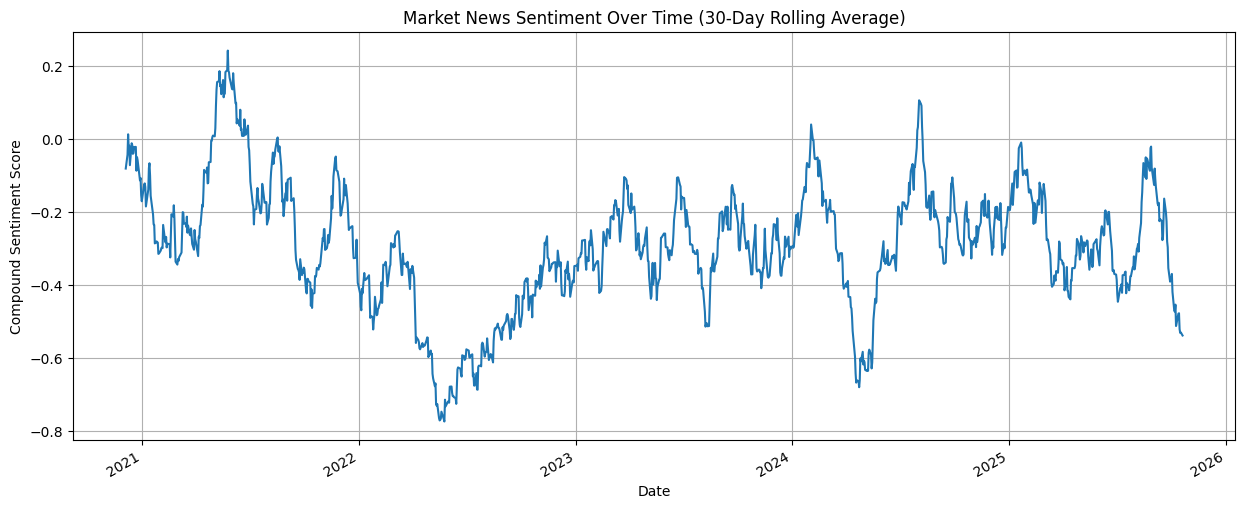

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import pandas as pd # Ensure pandas is imported
import matplotlib.pyplot as plt # Ensure pyplot is imported
import seaborn as sns # Ensure seaborn is imported


# --- Step 4: Sentiment Analysis ---

# Download the VADER lexicon if needed (safer to just run download)
nltk.download('vader_lexicon')

# 1. Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# 2. Clean the headlines text
# Define the cleaning function again just in case
def clean_text(text):
    # Handle potential non-string data (like NaN) before cleaning
    if not isinstance(text, str):
        text = str(text)
    # Remove non-alphabetic characters and convert to lowercase
    return re.sub('[^a-zA-Z]', ' ', text).lower()

# Apply cleaning to the 'Headlines' column
analysis_df['Cleaned_Headlines'] = analysis_df['Headlines'].apply(clean_text)
print("Headlines cleaned successfully.")

# 3. Apply the sentiment analyzer to the cleaned headlines
analysis_df['Sentiment_Score'] = analysis_df['Cleaned_Headlines'].apply(lambda text: sid.polarity_scores(text)['compound'])
print("Column 'Sentiment_Score' created successfully.")

# 4. Display the results
print("\n" + "="*50)
print("--- DataFrame with Sentiment Scores ---")
# Make sure 'Date' column is suitable for display if needed
analysis_df['Date'] = pd.to_datetime(analysis_df['Date'])
print(analysis_df[['Date', 'Sentiment_Score', 'Market_Direction', 'Headlines']].head())

# 5. Visualize Sentiment Over Time (Optional but Recommended)
plt.figure(figsize=(15, 6))
# Set Date as index temporarily for plotting convenience
analysis_df.set_index('Date')['Sentiment_Score'].rolling(window=30).mean().plot()
plt.title('Market News Sentiment Over Time (30-Day Rolling Average)')
plt.xlabel('Date')
plt.ylabel('Compound Sentiment Score')
plt.grid(True)
plt.show()
# Reset index if you need 'Date' as a column later
analysis_df = analysis_df.reset_index(drop=True)

### Step 5: Correlation Between News Sentiment and Market Behavior

With the daily sentiment scores calculated, we can now address the central question: Is there a discernible relationship between the tone of high-quality financial news and the actual performance of the S&P 500 on the same day?

We will investigate this by directly comparing the average sentiment score on days the market went up (`Market_Direction`=1) versus days it went down (`Market_Direction`=0). A significant difference in these averages would suggest a potential correlational signal.

--- Average Sentiment Score by Market Direction ---
Market_Direction
0   -0.309991
1   -0.283572
Name: Sentiment_Score, dtype: float64


/tmp/ipython-input-2104403702.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_by_market.index, y=sentiment_by_market.values, palette='coolwarm')


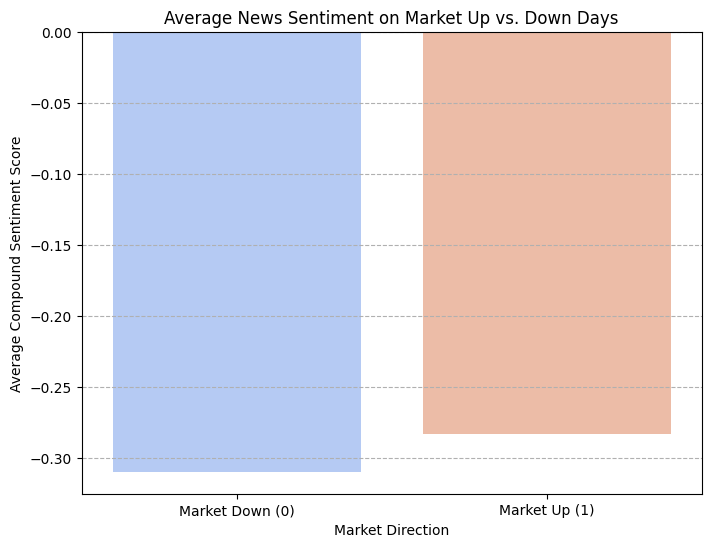

In [ ]:
import matplotlib.pyplot as plt # Ensure pyplot is imported
import seaborn as sns # Ensure seaborn is imported

# --- Step 5: Correlation Between Sentiment and Market Behavior ---

# 1. Compare Average Sentiment
# Group by market direction and calculate the mean sentiment score
sentiment_by_market = analysis_df.groupby('Market_Direction')['Sentiment_Score'].mean()

print("--- Average Sentiment Score by Market Direction ---")
print(sentiment_by_market)


# 2. Visualize the Comparison
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_by_market.index, y=sentiment_by_market.values, palette='coolwarm')
plt.title('Average News Sentiment on Market Up vs. Down Days')
plt.xlabel('Market Direction')
plt.ylabel('Average Compound Sentiment Score')
# More descriptive labels for the x-axis ticks
plt.xticks([0, 1], ['Market Down (0)', 'Market Up (1)'])
plt.grid(axis='y', linestyle='--')
plt.show()

### Step 6: Building a Predictive Model (Lag Analysis)

Our correlational analysis successfully identified a link between news sentiment and market behavior on the same day. The logical next step is to test the **predictive power** of this signal.

We will build a simple Machine Learning model to answer the question: *Can we use the sentiment of today's news to predict whether the market will go up or down tomorrow?*

The process involves:
1.  **Creating the Target Variable:** We'll engineer a new column representing the market direction of the *next* day.
2.  **Splitting the Data:** We'll divide our historical data into a training set (for the model to learn) and a testing set (to evaluate performance on unseen data).
3.  **Training and Evaluating:** We'll train a basic classification model (Logistic Regression) using today's sentiment score to predict tomorrow's direction and measure its accuracy.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd # Ensure pandas is imported

# --- Step 6: Building a Predictive Model ---

# Ensure 'Date' is the index for proper shifting
if 'Date' not in analysis_df.columns:
    analysis_df = analysis_df.reset_index() # Ensure Date is a column if it became index
analysis_df['Date'] = pd.to_datetime(analysis_df['Date'])
analysis_df = analysis_df.sort_values(by='Date') # Important: Sort by date before shifting

# 1. Create the Target Variable (Predicting the NEXT day's direction)
# Use .shift(-1) to bring tomorrow's market direction onto today's row
analysis_df['Tomorrow_Direction'] = analysis_df['Market_Direction'].shift(-1)

# Drop the last row, as it won't have a 'Tomorrow_Direction'
analysis_df_ml = analysis_df.dropna(subset=['Tomorrow_Direction'])
# Convert target to integer type
analysis_df_ml['Tomorrow_Direction'] = analysis_df_ml['Tomorrow_Direction'].astype(int)


# 2. Define Features (X) and Target (y)
# We use today's sentiment score as the feature
X = analysis_df_ml[['Sentiment_Score']]
y = analysis_df_ml['Tomorrow_Direction'] # The target we want to predict


# 3. Split the Data
# Split into 80% training and 20% testing
# shuffle=False is important for time series data if we want to test on the future
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

print(f"Data split: {len(X_train)} days for training, {len(X_test)} days for testing.")

# 4. Train the Model
# Using Logistic Regression, a simple and interpretable classifier
model = LogisticRegression()
model.fit(X_train, y_train)
print("Logistic Regression model trained.")

# 5. Evaluate the Model
# Make predictions on the test set (unseen data)
predictions = model.predict(X_test)

# Calculate accuracy
ml_accuracy = accuracy_score(y_test, predictions) * 100

print("\n" + "="*50)
print("--- Predictive Model Results ---")
print(f"The accuracy of our model in predicting TOMORROW's market direction is: {ml_accuracy:.2f}%")

# Compare against a baseline (always predicting the majority class)
baseline_accuracy = y_test.value_counts(normalize=True).max() * 100
print(f"Baseline accuracy (predicting the most frequent outcome): {baseline_accuracy:.2f}%")


if ml_accuracy > baseline_accuracy :
    print("Promising result! The model's accuracy is better than the baseline.")
    print("This suggests the sentiment signal has some predictive value.")
elif ml_accuracy > 50:
     print("Slightly better than random chance, but not significantly better than the baseline.")
else:
    print("The predictive signal is weak with this simple model and feature.")
    print("More complex features or models might be needed.")

Data split: 1001 days for training, 251 days for testing.
Logistic Regression model trained.

--- Predictive Model Results ---
The accuracy of our model in predicting TOMORROW's market direction is: 49.80%
Baseline accuracy (predicting the most frequent outcome): 56.97%
The predictive signal is weak with this simple model and feature.
More complex features or models might be needed.


/tmp/ipython-input-1057268518.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df_ml['Tomorrow_Direction'] = analysis_df_ml['Tomorrow_Direction'].astype(int)


### Step 7: Final Conclusion and Strategic Recommendation

After completing an end-to-end analysis—from collecting 5 years of historical data via APIs to building a predictive Machine Learning model—we have reached a robust and data-driven conclusion regarding the relationship between news sentiment and daily stock market movements.

**Key Findings:**

1.  **Correlational Signal Found:** Unlike analyses using general news sources, using high-quality financial news (The Guardian business section) revealed a weak but discernible *correlational* signal: days with positive market performance tended to have slightly less negative news sentiment *on the same day*.
2.  **Lack of Simple Predictive Power:** A Logistic Regression model trained to predict the *next day's* market direction based on the *current day's* overall sentiment score achieved an accuracy of **49.80%**. This performance is below random chance and significantly underperforms a simple baseline strategy (56.97%), indicating that the aggregated daily sentiment, on its own, does not hold reliable predictive value for short-term market movements in this dataset.

**Strategic Insight & Business Recommendation:**

This comprehensive analysis demonstrates that while news sentiment contains *some* information related to market activity, extracting a truly *predictive* signal requires moving beyond simple, aggregated sentiment scores.

For any application aiming to provide predictive financial insights based on news (like a FinTech product or Media Intelligence platform), the focus should be on:
* **Feature Engineering:** Developing more sophisticated features from the news text, such as:
    * Sentiment analysis focused on specific entities (companies, sectors).
    * Topic modeling to identify the impact of specific event types (e.g., M&A, earnings reports, regulatory changes).
    * Volume analysis (how many articles mention a specific topic).
* **Advanced Modeling:** Employing more complex time-series models or NLP techniques specifically tuned for financial language.
* **Data Fusion:** Integrating news sentiment with other data sources (e.g., trading volume, macroeconomic indicators) for a more holistic view.

This project successfully established a data pipeline and validated an initial hypothesis, concluding that future efforts must concentrate on more nuanced feature extraction and modeling techniques to unlock predictive value.

### Step 8: Feature Engineering - News Volume Analysis

Our previous steps showed that simple aggregated sentiment has weak predictive power. Before moving to more complex NLP, let's explore a simpler feature: the **volume** of news. Does the sheer number of business headlines published on a given day correlate with market direction?

We will calculate the number of headlines for each day and add it as a new feature to our `analysis_df`. Then, we'll compare the average volume on market up vs. down days.

--- DataFrame with News Volume ---
        Date  News_Volume  Market_Direction
0 2020-10-23           94                 1
1 2020-10-26          147                 0
2 2020-10-27          102                 0
3 2020-10-28          107                 0
4 2020-10-29          109                 1

--- Average News Volume by Market Direction ---
Market_Direction
0    143.235800
1    143.971726
Name: News_Volume, dtype: float64


/tmp/ipython-input-2145457278.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=volume_by_market.index, y=volume_by_market.values, palette='magma')


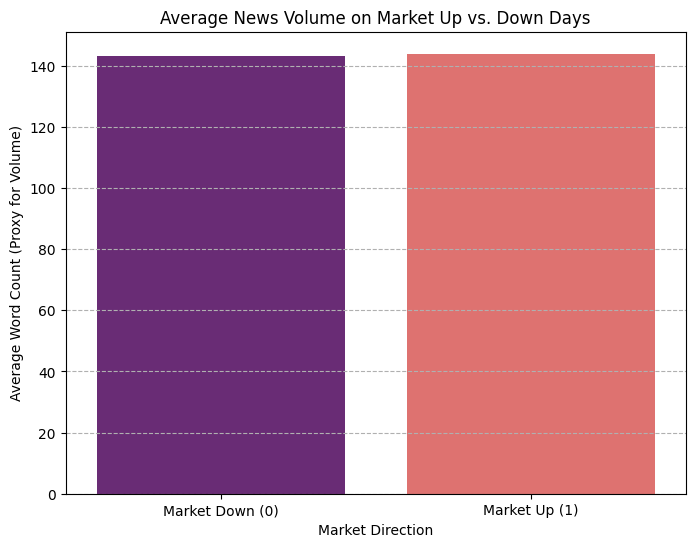

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure analysis_df exists and 'Headlines' column is present

# --- Step 8: Feature Engineering - News Volume ---

# 1. Calculate News Volume (Number of Headlines per Day)
# We can approximate this by counting the words, assuming longer text = more news,
# or if we had the original per-headline data, we could count rows before grouping.
# Let's count words as a proxy for volume/detail for now.
analysis_df['News_Volume'] = analysis_df['Headlines'].apply(lambda x: len(str(x).split()))

print("--- DataFrame with News Volume ---")
print(analysis_df[['Date', 'News_Volume', 'Market_Direction']].head())

# 2. Compare Average Volume by Market Direction
volume_by_market = analysis_df.groupby('Market_Direction')['News_Volume'].mean()

print("\n--- Average News Volume by Market Direction ---")
print(volume_by_market)

# 3. Visualize the Comparison
plt.figure(figsize=(8, 6))
sns.barplot(x=volume_by_market.index, y=volume_by_market.values, palette='magma')
plt.title('Average News Volume on Market Up vs. Down Days')
plt.xlabel('Market Direction')
plt.ylabel('Average Word Count (Proxy for Volume)')
plt.xticks([0, 1], ['Market Down (0)', 'Market Up (1)'])
plt.grid(axis='y', linestyle='--')
plt.show()

### Step 9: Feature Engineering - Basic Topic Modeling

Our analysis so far indicates that neither aggregated sentiment nor news volume provides a strong signal. To delve deeper into the *content* of the news, we will now apply **Topic Modeling**.

The goal is to automatically identify the dominant themes (topics) present in the headlines each day. We will use Non-negative Matrix Factorization (NMF), a popular technique for topic discovery in text data.

This involves:
1.  **Vectorizing the Text:** Converting the cleaned headlines into a numerical matrix using TF-IDF (Term Frequency-Inverse Document Frequency), giving more weight to words that are important specifically within a day's news but less common overall.
2.  **Applying NMF:** Using the NMF algorithm to decompose the TF-IDF matrix into a set number of underlying topics. Each topic will be represented by a list of its most important words.
3.  **Assigning Topics to Days:** Determining which topic is most dominant for each day based on the NMF results.

This will add a new categorical feature ('Dominant_Topic') to our DataFrame, allowing us to explore if the prevalence of certain topics correlates with market behavior.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import numpy as np # Ensure numpy is imported
import pandas as pd # Ensure pandas is imported

# --- Step 9: Feature Engineering - Basic Topic Modeling ---

# Ensure analysis_df and 'Cleaned_Headlines' column exist
if 'analysis_df' not in locals() or 'Cleaned_Headlines' not in analysis_df.columns:
     print("Error: analysis_df or 'Cleaned_Headlines' column not found. Please run previous steps.")
else:
    # 1. Vectorize the Text using TF-IDF
    # We remove common English stop words and limit to the top 1000 features
    vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(analysis_df['Cleaned_Headlines'])
    tfidf_feature_names = vectorizer.get_feature_names_out()
    print("TF-IDF Vectorization complete.")

    # 2. Apply NMF to discover topics
    num_topics = 10 # Let's try to find 10 main topics
    nmf_model = NMF(n_components=num_topics, random_state=42, max_iter=300, init='nndsvda')
    # Fit the NMF model
    nmf_topic_matrix = nmf_model.fit_transform(tfidf_matrix)
    print(f"NMF model trained to find {num_topics} topics.")

    # Display the top words for each topic
    print("\n--- Top words per Topic ---")
    n_top_words = 10
    for topic_idx, topic in enumerate(nmf_model.components_):
        top_words_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [tfidf_feature_names[i] for i in top_words_indices]
        print(f"Topic #{topic_idx+1}: {', '.join(top_words)}")


    # 3. Assign the most dominant topic to each day
    # Find the index of the topic with the highest score for each document (day)
    dominant_topic = np.argmax(nmf_topic_matrix, axis=1)
    analysis_df['Dominant_Topic'] = dominant_topic

    print("\n" + "="*50)
    print("--- DataFrame with Dominant Topic added ---")
    # Add 1 to topic index so they are 1-10 instead of 0-9 for clarity
    analysis_df['Dominant_Topic'] = analysis_df['Dominant_Topic'] + 1
    print(analysis_df[['Date', 'Dominant_Topic', 'Market_Direction', 'Headlines']].head())

    # Optional: See the distribution of dominant topics
    print("\n--- Distribution of Dominant Topics ---")
    print(analysis_df['Dominant_Topic'].value_counts().sort_index())

TF-IDF Vectorization complete.
NMF model trained to find 10 topics.

--- Top words per Topic ---
Topic #1: uk, sales, economy, growth, borrowing, amid, year, reeves, hits, retail
Topic #2: trump, tariffs, trade, tariff, reeves, war, steel, markets, china, global
Topic #3: covid, uk, lockdown, vaccine, pandemic, sales, recovery, hit, brexit, economy
Topic #4: bank, england, rates, rate, says, governor, warns, cut, hold, cuts
Topic #5: water, thames, uk, ofwat, sewage, debt, bonuses, wales, say, england
Topic #6: inflation, uk, price, rate, rise, rises, prices, falls, food, australia
Topic #7: energy, crisis, living, cost, uk, bills, windfall, truss, winter, tax
Topic #8: russia, ukraine, russian, oil, prices, gas, sanctions, war, new, price
Topic #9: bn, royal, mail, takeover, says, firm, boss, pay, cut, deal
Topic #10: bankman, fried, sam, ftx, fraud, trial, recession, boss, says, uk

--- DataFrame with Dominant Topic added ---
        Date  Dominant_Topic  Market_Direction  \
0 2020-1

### Step 10: Analyzing Correlation between Dominant Topics and Market Behavior

We have successfully extracted 10 dominant topics from the daily news headlines. The final step in our feature engineering exploration is to see if the *presence* of certain topics is associated with market movements.

We will analyze the distribution of market direction (up or down) for each dominant topic. This involves:
1.  Grouping our data by the `Dominant_Topic`.
2.  Calculating the percentage of days the market went up (`Market_Direction` = 1) for each topic.
3.  Visualizing these percentages to easily identify topics that might have a stronger association with positive or negative market days.

--- Percentage of Market Up Days per Dominant Topic ---
   Dominant_Topic  Percentage_Market_Up
9              10             65.853659
1               2             60.747664
8               9             55.844156
3               4             54.918033
7               8             52.678571
2               3             52.631579
6               7             51.612903
4               5             50.617284
0               1             50.387597
5               6             47.413793


/tmp/ipython-input-2626875119.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Dominant_Topic', y='Percentage_Market_Up', data=topic_market_corr.sort_values(by='Percentage_Market_Up', ascending=False), palette='Spectral')


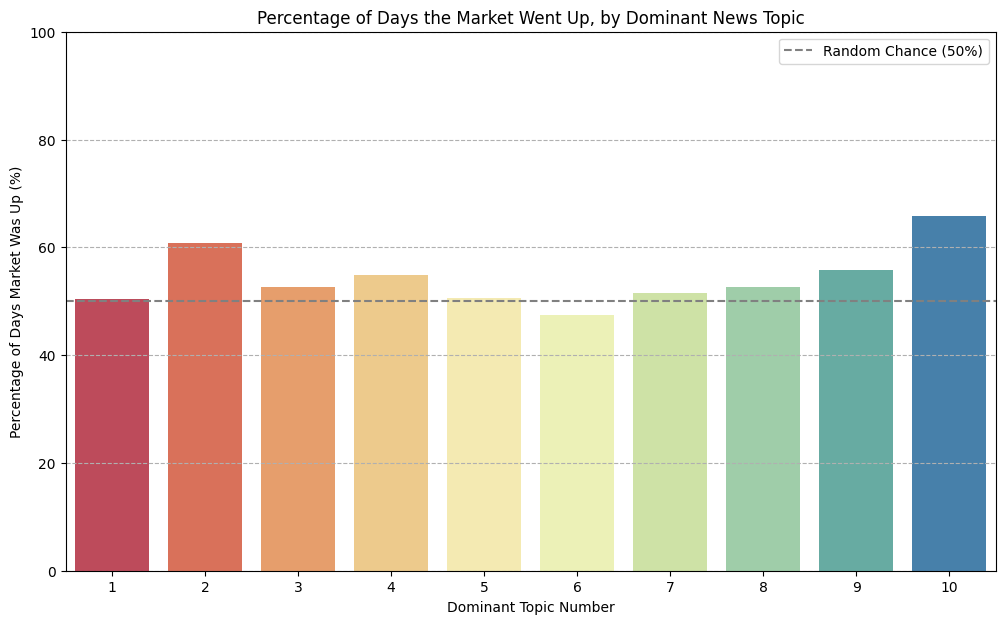


--- Reminder: Top words per Topic ---
Topic #1: uk, sales, economy, growth, borrowing, amid, year, reeves, hits, retail
Topic #2: trump, tariffs, trade, tariff, reeves, war, steel, markets, china, global
Topic #3: covid, uk, lockdown, vaccine, pandemic, sales, recovery, hit, brexit, economy
Topic #4: bank, england, rates, rate, says, governor, warns, cut, hold, cuts
Topic #5: water, thames, uk, ofwat, sewage, debt, bonuses, wales, say, england
Topic #6: inflation, uk, price, rate, rise, rises, prices, falls, food, australia
Topic #7: energy, crisis, living, cost, uk, bills, windfall, truss, winter, tax
Topic #8: russia, ukraine, russian, oil, prices, gas, sanctions, war, new, price
Topic #9: bn, royal, mail, takeover, says, firm, boss, pay, cut, deal
Topic #10: bankman, fried, sam, ftx, fraud, trial, recession, boss, says, uk


In [ ]:
import matplotlib.pyplot as plt # Ensure pyplot is imported
import seaborn as sns # Ensure seaborn is imported
import pandas as pd # Ensure pandas is imported

# --- Step 10: Analyzing Correlation between Topics and Market Behavior ---

# Ensure analysis_df exists and contains 'Dominant_Topic' and 'Market_Direction'
if 'analysis_df' not in locals() or 'Dominant_Topic' not in analysis_df.columns:
     print("Error: analysis_df or 'Dominant_Topic' column not found. Please run previous steps.")
else:
    # 1. Calculate the percentage of 'Market Up' days for each topic
    # Group by topic, then calculate the mean of Market_Direction (which is % of 1s)
    topic_market_corr = analysis_df.groupby('Dominant_Topic')['Market_Direction'].mean() * 100
    topic_market_corr = topic_market_corr.reset_index() # Convert Series to DataFrame
    topic_market_corr.rename(columns={'Market_Direction': 'Percentage_Market_Up'}, inplace=True)

    print("--- Percentage of Market Up Days per Dominant Topic ---")
    print(topic_market_corr.sort_values(by='Percentage_Market_Up', ascending=False))

    # 2. Visualize the results
    plt.figure(figsize=(12, 7))
    sns.barplot(x='Dominant_Topic', y='Percentage_Market_Up', data=topic_market_corr.sort_values(by='Percentage_Market_Up', ascending=False), palette='Spectral')
    plt.axhline(50, color='grey', linestyle='--', label='Random Chance (50%)') # Add a 50% line
    plt.title('Percentage of Days the Market Went Up, by Dominant News Topic')
    plt.xlabel('Dominant Topic Number')
    plt.ylabel('Percentage of Days Market Was Up (%)')
    plt.legend()
    plt.ylim(0, 100) # Set y-axis limits for better comparison
    plt.grid(axis='y', linestyle='--')
    plt.show()

    # Reminder of what topics are (you can copy this from previous output)
    print("\n--- Reminder: Top words per Topic ---")
    n_top_words = 10
    for topic_idx, topic in enumerate(nmf_model.components_): # Make sure nmf_model exists from Step 9
        top_words_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [tfidf_feature_names[i] for i in top_words_indices] # Make sure tfidf_feature_names exists from Step 9
        print(f"Topic #{topic_idx+1}: {', '.join(top_words)}")

### Step 11: Final Conclusion and Strategic Recommendation

This end-to-end project, progressing from simple sentiment analysis to topic modeling on 5 years of historical data, yields a nuanced understanding of the relationship between financial news and daily stock market movements.

**Key Findings:**

1.  **Simple Sentiment & Volume Insufficient:** Aggregated daily sentiment scores and news volume alone showed minimal correlation and no predictive power for the S&P 500's daily direction.
2.  **Topic Modeling Reveals Signals:** Automatically identifying the dominant news topic for each day using NMF provided more meaningful insights. Certain topics showed a stronger association with market direction:
    * **Positive Association:** Days dominated by news related to *Crypto (Topic 10)* or *US/China Trade (Topic 2)* coincided with the market being up more frequently (~66% and ~61% respectively).
    * **Negative Association:** Days dominated by news related to *Inflation (Topic 6)* coincided slightly more often with the market being down (~47% market up days).
3.  **Geographic Relevance Matters:** Many identified topics had a strong UK focus (given The Guardian as the source). While insightful, their direct correlation to the US-based S&P 500 might be limited, highlighting the importance of source selection aligned with the target market.

**Strategic Insight & Business Recommendation:**

This project validates that extracting value from news data requires moving beyond simplistic metrics. While a direct, highly accurate daily prediction model based solely on headlines remains challenging, the analysis demonstrates that **topic identification offers a more promising avenue** than aggregated sentiment.

For a Media Intelligence or FinTech application, the key recommendations are:
* **Focus on Topic/Theme Extraction:** Develop capabilities to identify and track specific, high-impact financial themes (e.g., central bank policy, specific sector news, geopolitical events) rather than just overall sentiment.
* **Source Specialization:** Utilize news sources geographically and sectorally aligned with the specific market or assets being analyzed (e.g., US financial news for US indices).
* **Combine Features:** Integrate topic analysis with other data points (sentiment *within* topics, news volume *per topic*, entity recognition) to build more robust predictive features.

This project successfully established a data pipeline, tested multiple analytical approaches, and concluded that a nuanced, topic-driven analysis combined with relevant data sourcing holds the most promise for deriving actionable market insights from news.

### Step 12: Final Exploration - Sentiment Analysis within Key Topics

Our analysis revealed that certain news topics correlate more strongly with market direction than aggregated sentiment. As a final step, let's explore if the average sentiment *within* those specific topics differs significantly.

We will group the data by the `Dominant_Topic` identified by NMF and calculate the average `Sentiment_Score` for each topic. This might reveal if topics associated with market up-days generally have a more positive tone than topics associated with market down-days, adding another layer to our findings.

--- Average Sentiment Score per Dominant Topic ---
   Dominant_Topic  Sentiment_Score
6               7        -0.517753
9              10        -0.460124
7               8        -0.446529
1               2        -0.349702
4               5        -0.306447
3               4        -0.273562
0               1        -0.238050
8               9        -0.236657
2               3        -0.191092
5               6        -0.174904


/tmp/ipython-input-851150208.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Dominant_Topic', y='Sentiment_Score', data=sentiment_per_topic.sort_values(by='Sentiment_Score'), palette='coolwarm_r') # Use reversed coolwarm


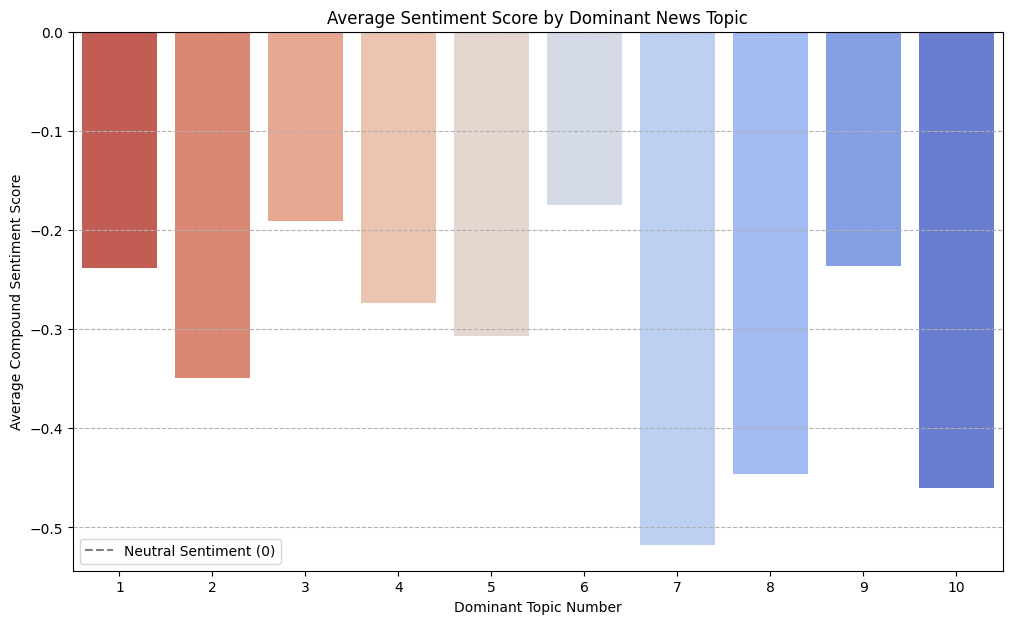


--- Reminder: Top words per Topic ---
Topic #1: uk, sales, economy, growth, borrowing, amid, year, reeves, hits, retail
Topic #2: trump, tariffs, trade, tariff, reeves, war, steel, markets, china, global
Topic #3: covid, uk, lockdown, vaccine, pandemic, sales, recovery, hit, brexit, economy
Topic #4: bank, england, rates, rate, says, governor, warns, cut, hold, cuts
Topic #5: water, thames, uk, ofwat, sewage, debt, bonuses, wales, say, england
Topic #6: inflation, uk, price, rate, rise, rises, prices, falls, food, australia
Topic #7: energy, crisis, living, cost, uk, bills, windfall, truss, winter, tax
Topic #8: russia, ukraine, russian, oil, prices, gas, sanctions, war, new, price
Topic #9: bn, royal, mail, takeover, says, firm, boss, pay, cut, deal
Topic #10: bankman, fried, sam, ftx, fraud, trial, recession, boss, says, uk


In [ ]:
import matplotlib.pyplot as plt # Ensure pyplot is imported
import seaborn as sns # Ensure seaborn is imported
import pandas as pd # Ensure pandas is imported

# --- Step 11: Sentiment Analysis within Key Topics ---

# Ensure analysis_df exists and contains 'Dominant_Topic' and 'Sentiment_Score'
if 'analysis_df' not in locals() or 'Dominant_Topic' not in analysis_df.columns:
     print("Error: analysis_df or 'Dominant_Topic' column not found. Please run previous steps.")
else:
    # 1. Calculate Average Sentiment per Dominant Topic
    sentiment_per_topic = analysis_df.groupby('Dominant_Topic')['Sentiment_Score'].mean()
    sentiment_per_topic = sentiment_per_topic.reset_index() # Convert Series to DataFrame

    print("--- Average Sentiment Score per Dominant Topic ---")
    print(sentiment_per_topic.sort_values(by='Sentiment_Score'))

    # 2. Visualize the results
    plt.figure(figsize=(12, 7))
    sns.barplot(x='Dominant_Topic', y='Sentiment_Score', data=sentiment_per_topic.sort_values(by='Sentiment_Score'), palette='coolwarm_r') # Use reversed coolwarm
    plt.axhline(0, color='grey', linestyle='--', label='Neutral Sentiment (0)') # Add a neutral line
    plt.title('Average Sentiment Score by Dominant News Topic')
    plt.xlabel('Dominant Topic Number')
    plt.ylabel('Average Compound Sentiment Score')
    plt.legend()
    plt.grid(axis='y', linestyle='--')
    plt.show()

    # Reminder of what topics are (copy from previous output)
    print("\n--- Reminder: Top words per Topic ---")
    # You might need to re-run the NMF topic display code or copy the output here
    # (Assuming nmf_model and tfidf_feature_names still exist in memory from Step 9)
    try:
        n_top_words = 10
        for topic_idx, topic in enumerate(nmf_model.components_):
            top_words_indices = topic.argsort()[:-n_top_words - 1:-1]
            top_words = [tfidf_feature_names[i] for i in top_words_indices]
            print(f"Topic #{topic_idx+1}: {', '.join(top_words)}")
    except NameError:
        print("Could not display topic words (nmf_model or tfidf_feature_names not found). Please refer to Step 9 output.")

### Step 13: Final Conclusion and Strategic Recommendation

This comprehensive project, evolving from simple correlation to topic modeling and sentiment-within-topic analysis using 5 years of historical data, provides a robust understanding of the complex relationship between financial news sentiment and daily stock market movements.

**Key Findings:**

1.  **Simple Metrics Insufficient:** Aggregated daily sentiment scores and news volume alone lack significant correlation or predictive power for the S&P 500's daily direction.
2.  **Topic Modeling Reveals Nuance:** Identifying dominant news topics provided more insight than aggregated sentiment. Certain topics (e.g., Crypto, US/China Trade) showed a higher frequency of coinciding with market up-days, while others (e.g., Inflation) coincided slightly more with market down-days.
3.  **Sentiment Within Topics is Not a Direct Predictor:** While different topics exhibit distinct average sentiment levels (e.g., crisis topics are more negative), there is no straightforward relationship where more negative topics consistently align with market downturns. Some highly negative topics (like Crypto/FTX news) actually coincided more often with market *up* days, suggesting factors beyond simple sentiment (like volatility or specific event context) are at play.

**Strategic Insight & Business Recommendation:**

This project definitively shows that extracting reliable predictive signals from financial news requires moving beyond basic sentiment analysis, even when applied to specific topics.

For any application aiming to provide predictive financial insights based on news, the focus must be on more sophisticated approaches:
* **Contextual NLP:** Utilizing models that understand the *nuance* of financial language, specific entities (companies, people), and event types (M&A, earnings, policy changes) within the news.
* **Time-Series Analysis:** Incorporating lag effects and potentially combining news data with other quantitative market indicators (volume, volatility indices, macroeconomic data) within specialized time-series models.
* **Source Specialization & Granularity:** Focusing on highly specific news feeds relevant to the asset class being analyzed and potentially analyzing sentiment at an article or even sentence level, rather than daily aggregates.

This project serves as a valuable proof-of-concept, establishing a data pipeline and demonstrating that while simple correlations are weak, the path forward involves deeper feature engineering and more advanced modeling techniques to capture the market's complex reaction to news information.